# **Modelling and Evaluation**

## Objectives

* This notebook aims to answer Hypothesis 2:

The Base model created in the last notebook will be compared to a model using images with 100 x 100 pixels instead of the original image size


## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings: outputs/v1/image_shape.pkl
* Base model: outputs/v1/mildew_detector_model.h5

## Outputs

* Image augmentation.
* Machine learning model creation and training.
* Saved model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Conclusion

The hypothesis was invalidated. 

---

# Prepare Data Directories

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project'

## Set input directories

In [5]:
data_directory = 'inputs/cherry_leaves_dataset/cherry-leaves/'
train_path = os.path.join(data_directory, 'train')
val_path = os.path.join(data_directory, 'validation')
test_path = os.path.join(data_directory, 'test')

## Set output directory

Next we set our output directory, making sure to add a version number so we can version outputs from different sessions.

In [6]:
version = 2
output_path = f'outputs/v{version}'

if 'outputs' in os.listdir(os.getcwd()) and f'v{version}' in os.listdir(os.path.join(os.getcwd(), 'outputs')):
    print('Version already exists, create a new version')
else:
    os.makedirs(name = output_path)

Version already exists, create a new version


### Set label names

In [7]:
labels = os.listdir(train_path)
print(f'Labels for the images are {labels}')

Labels for the images are ['powdery_mildew', 'healthy']


### Set image shape

We need to import the image shape embedding we previously saved as a .pkl file. 

In [8]:
import joblib
original_image_shape = joblib.load(filename=f'outputs/v1/image_shape.pkl')
original_image_shape


(256, 256, 3)

Define the new image shape:

In [9]:
resized_image_shape = (100, 100, 3)
resized_image_shape

(100, 100, 3)

---

# Model with images resized to 100 x 100 pixels

# Image augmentation

We use the image augmentation step to also resize our images to the `resized_image_shape`.

### Initialize ImagaDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [11]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=resized_image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=resized_image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=resized_image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

We plot some samples from the augmented images to check that we still see the relevant features and we can also see that they were correctly resized.

(20, 100, 100, 3)


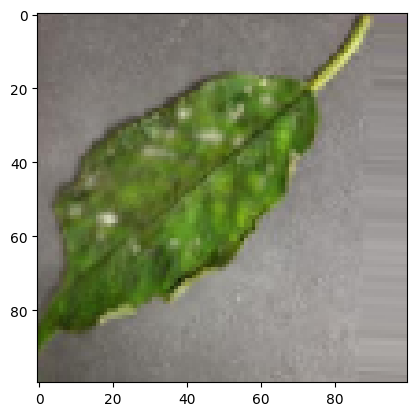

(20, 100, 100, 3)


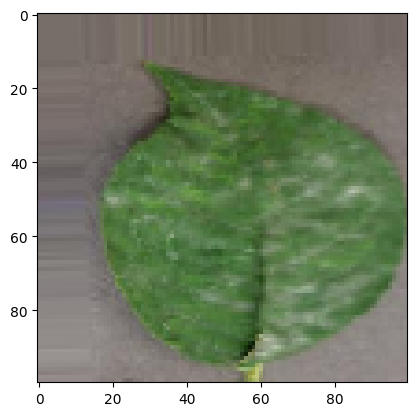

(20, 100, 100, 3)


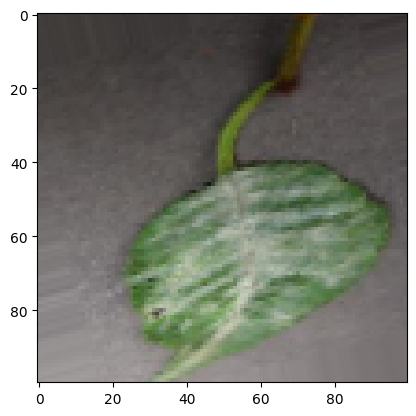

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,100,100,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images

(20, 100, 100, 3)


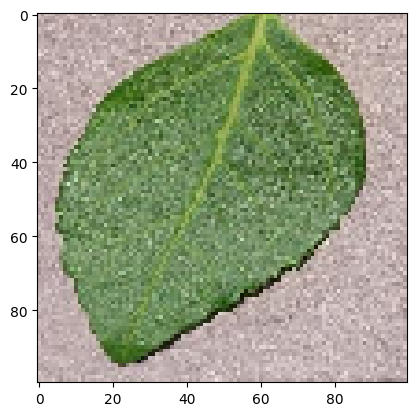

(20, 100, 100, 3)


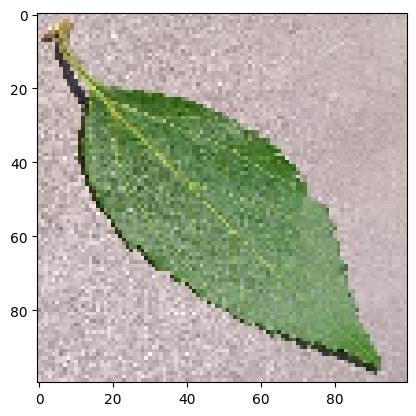

(20, 100, 100, 3)


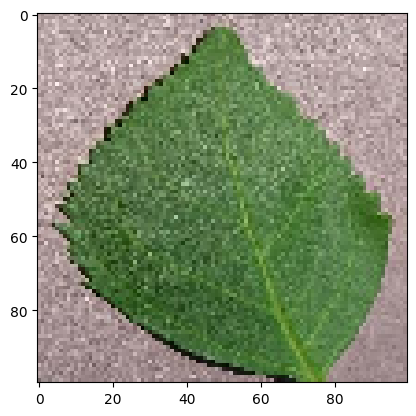

In [15]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,100,100,3)
    plt.imshow(img[0])
    plt.show()

(20, 100, 100, 3)


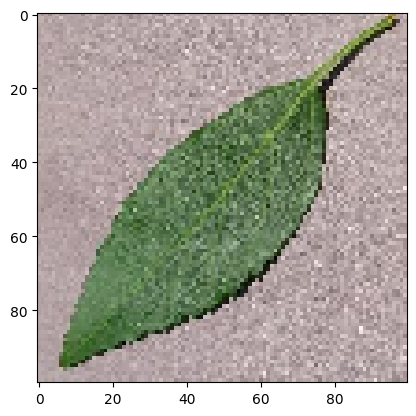

(20, 100, 100, 3)


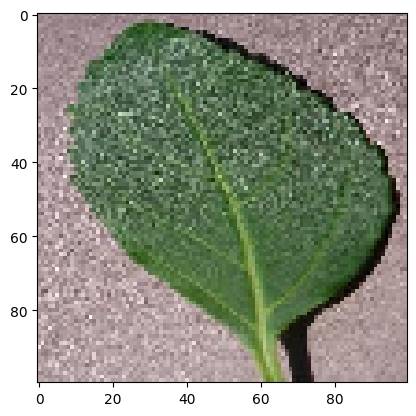

(20, 100, 100, 3)


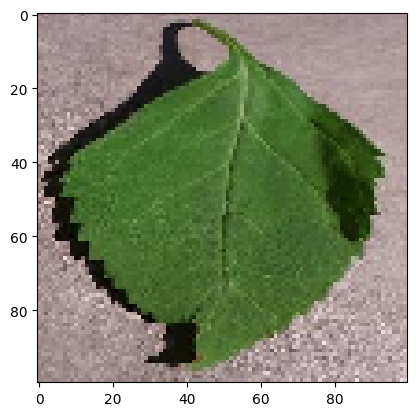

In [16]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,100,100,3)
    plt.imshow(img[0])
    plt.show()

---

## Model creation - resized images

### Importing model packages

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

As a base ML model, we go with a Convolutional Neural Network, using Tensorflow's Sequential model. 
We will use 

In [19]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(2, 2),
              input_shape=resized_image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(2, 2),
              input_shape=resized_image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(2, 2),
              input_shape=resized_image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model


### Model Summary

In [20]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 99, 16)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0

2023-11-12 13:25:17.737282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping

In order to not overfit our model, we add a function to stop the training of the model early.

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fitting the model for training

In [22]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-11-12 13:25:25.814769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 16s 106ms/step - loss: 0.6690 - accuracy: 0.5964 - val_loss: 0.6423 - val_accuracy: 0.5548
Epoch 2/25
147/147 [==============================] - 16s 109ms/step - loss: 0.6296 - accuracy: 0.6966 - val_loss: 0.5800 - val_accuracy: 0.7381
Epoch 3/25
147/147 [==============================] - 17s 119ms/step - loss: 0.5496 - accuracy: 0.7886 - val_loss: 0.4709 - val_accuracy: 0.8643
Epoch 4/25
147/147 [==============================] - 18s 126ms/step - loss: 0.4649 - accuracy: 0.8198 - val_loss: 0.3732 - val_accuracy: 0.9095
Epoch 5/25
147/147 [==============================] - 19s 132ms/step - loss: 0.3888 - accuracy: 0.8454 - val_loss: 0.3129 - val_accuracy: 0.8857
Epoch 6/25
147/147 [==============================] - 16s 111ms/step - loss: 0.3412 - accuracy: 0.8670 - val_loss: 0.2682 - val_accuracy: 0.9095
Epoch 7/25
147/147 [==============================] - 17s 112ms/step - loss: 0.3288 - accuracy: 0.8659 - val_loss: 0.2493 - val_ac

### Save the model

In [23]:
model.save('outputs/v2/mildew_detector_model-resized.h5')

---

# Model Performance

There are several different ways to assess the performance of our model. 

## Model learning curve

First, we can assess the model learning curve. We look at the loss and accuracy of our train set and validation set. We want the loss to get smaller over the epochs and the accuracy to get higher over the epochs. In an ideal model, the loss of the train set will tend to 0 and the accuracy of the train set will tend to 1, and the loss and accuracy of the validation set will have a very similar progression. 

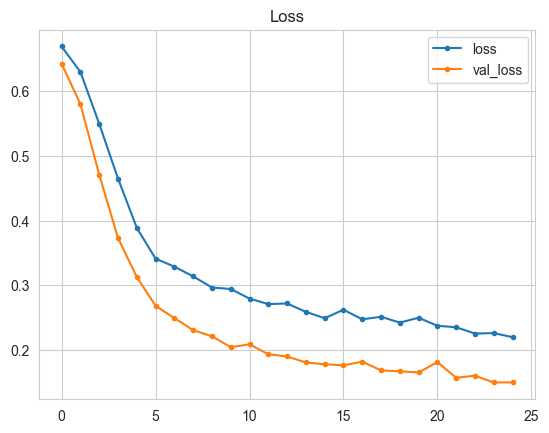

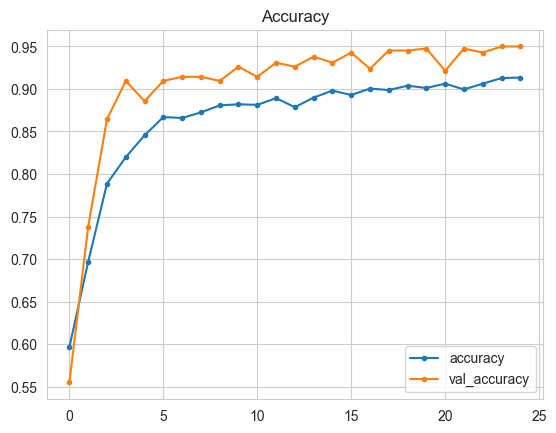

In [24]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{output_path}/model_training_losses-resized.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{output_path}/model_training_acc-resized.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Next we can evaluate the absolute loss and accuracy of the model using the keras library and run it on unseen data, i.e. our labelled test set. 

We load the model we saved earlier:

In [25]:
from keras.models import load_model
model = load_model('outputs/v2/mildew_detector_model-resized.h5')

We evaluate the model on the test set:

In [26]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 2s 44ms/step - loss: 0.1588 - accuracy: 0.9360


We save the evaluation as a .pkl file:

In [27]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation-resized.pkl")

['outputs/v2/evaluation-resized.pkl']

## Predict on new data

As a manual confirmation, we try if the prediction is accurate on any image we load.

We load any image from our test set (code is adapted and adjusted from the CI Malaria walkthrough):

Image shape: (100, 100), Image mode: RGB


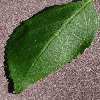

In [37]:
from tensorflow.keras.preprocessing import image

pointer = 61
label = labels[1]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=resized_image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

We need to convert the image to an array using numpy:

In [38]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


And then we predict the class probability:

In [39]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.5395996
powdery_mildew


---

## Conclusion of comparison for Hypothesis 2

While the model was trained in a fraction of the time than the original model at 7 minutes for all 25 epochs and the training and loss plots do not look bad at first glance, we see that clearly, the model does not perform as well as the model with the original size of 256 x 256 pixels when we do the evaluation on the test set. The accuracy only comes up to 93.6%. 

We could try to tweak the model further to see if we could get a better performance, but I am not sure this would work. Looking at the image samples we plotted further above in the notebook, at 100 x 100 pixels the leaves look quite pixelated and the dominant features of the affected leaves are not as clearly distinguishable as on the original size. Therefore, I deem the hypothesis that the model performs similarly on smaller sized pictures as invalidated. 